In [ ]:
!pip install catboost

In [ ]:
import os
import shutil
import random
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import lightgbm as lgbm
from google.colab import files
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import precision_score
import torch
import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.autograd import Variable

In [ ]:
random.seed(22)

In [ ]:
files.upload(); #animals_data.zip

In [ ]:
data_dir = '/content/data'

In [ ]:
shutil.unpack_archive('/content/animals_data.zip', data_dir)

In [ ]:
df = pd.read_csv(os.path.join(data_dir, 'animals_data.csv'))
print("Строк в датасете: {}".format(len(df)))
df.head()

Строк в датасете: 967


,id,cat,cow,dog,horse,sheep,bounds_x,bounds_y,bounds_width,bounds_height,L_eye_v,L_eye_x,L_eye_y,R_eye_v,R_eye_x,R_eye_y,L_ear_v,L_ear_x,L_ear_y,R_ear_v,R_ear_x,R_ear_y,Nose_v,Nose_x,Nose_y,Throat_v,Throat_x,Throat_y,Tail_v,Tail_x,Tail_y,withers_v,withers_x,withers_y,L_F_elbow_v,L_F_elbow_x,L_F_elbow_y,R_F_elbow_v,R_F_elbow_x,R_F_elbow_y,L_B_elbow_v,L_B_elbow_x,L_B_elbow_y,R_B_elbow_v,R_B_elbow_x,R_B_elbow_y,L_F_knee_v,L_F_knee_x,L_F_knee_y,R_F_knee_v,R_F_knee_x,R_F_knee_y,L_B_knee_v,L_B_knee_x,L_B_knee_y,R_B_knee_v,R_B_knee_x,R_B_knee_y,L_F_paw_v,L_F_paw_x,L_F_paw_y,R_F_paw_v,R_F_paw_x,R_F_paw_y,L_B_paw_v,L_B_paw_x,L_B_paw_y,R_B_paw_v,R_B_paw_x,R_B_paw_y,stand,sit,lie,go,run,jump,interact,sleep,eat
0,0,1,0,0,0,0,2,5,296,204,1,178,71,1,132,65,1,203,33,1,117,19,1,154,86,1,157,119,0,0,0,0,0,0,1,213,146,1,94,130,0,0,0,0,0,0,1,265,162,1,72,158,0,0,0,0,0,0,0,0,0,1,6,174,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1,1,0,0,0,0,20,8,260,286,1,202,145,1,99,149,1,248,46,1,46,56,1,147,190,1,146,276,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,1,0,0,0,0,5,11,282,224,1,190,129,1,130,125,1,240,75,1,102,61,1,160,136,1,154,200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,1,0,0,0,0,9,13,274,228,1,221,85,1,179,91,1,245,33,1,145,40,1,200,92,1,205,130,1,46,127,1,124,72,1,232,175,1,130,170,0,0,0,1,63,179,1,210,201,1,149,206,0,0,0,1,75,206,1,218,227,1,144,233,0,0,0,1,87,221,1,0,0,0,0,0,0,0,0
4,4,1,0,0,0,0,25,0,236,220,1,178,79,1,114,99,1,195,20,1,47,48,1,156,118,1,160,164,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
classes = ['stand', 'sit', 'lie', 'go', 'run', 'jump', 'interact', 'sleep', 'eat']
X = df.drop(classes, axis=1)
y = df[['id'] + classes]

In [ ]:
for column in X.columns:
    if '_x' in column or '_width' in column or '_y' in column or '_height' in column:
        X[column] = X[column].astype(float)

df_dict = X.to_dict()

for idx in df_dict['id'].values():
    img_name = os.path.join(data_dir, 'animals', "0"*(3-len(str(idx))) + str(idx) + ".jpeg")
    image = Image.open(img_name)
    x_size, y_size = image.size
    for column in df_dict.keys():
        if '_x' in column or '_width' in column:
            df_dict[column][idx] /= x_size
        elif '_y' in column or '_height' in column:
            df_dict[column][idx] /= y_size

X = pd.DataFrame.from_dict(df_dict)

In [ ]:
y['label'] = 0
for idx in range(1, len(y.columns)-1):
    y['label'] += y[y.columns[idx]] * idx

In [ ]:
X.set_index('id', inplace=True)
y.set_index('id', inplace=True)

In [ ]:
X['animal'] = 0
for idx in range(5):
    X['animal'] += X[X.columns[idx]] * idx

X = X.drop(['cat', 'cow', 'dog', 'horse', 'sheep'], axis=1)

X['bounds_width'] += X['bounds_x']
X['bounds_height'] += X['bounds_y']

In [ ]:
X.head()

,bounds_x,bounds_y,bounds_width,bounds_height,L_eye_v,L_eye_x,L_eye_y,R_eye_v,R_eye_x,R_eye_y,L_ear_v,L_ear_x,L_ear_y,R_ear_v,R_ear_x,R_ear_y,Nose_v,Nose_x,Nose_y,Throat_v,Throat_x,Throat_y,Tail_v,Tail_x,Tail_y,withers_v,withers_x,withers_y,L_F_elbow_v,L_F_elbow_x,L_F_elbow_y,R_F_elbow_v,R_F_elbow_x,R_F_elbow_y,L_B_elbow_v,L_B_elbow_x,L_B_elbow_y,R_B_elbow_v,R_B_elbow_x,R_B_elbow_y,L_F_knee_v,L_F_knee_x,L_F_knee_y,R_F_knee_v,R_F_knee_x,R_F_knee_y,L_B_knee_v,L_B_knee_x,L_B_knee_y,R_B_knee_v,R_B_knee_x,R_B_knee_y,L_F_paw_v,L_F_paw_x,L_F_paw_y,R_F_paw_v,R_F_paw_x,R_F_paw_y,L_B_paw_v,L_B_paw_x,L_B_paw_y,R_B_paw_v,R_B_paw_x,R_B_paw_y,animal
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.006667,0.023810,0.993333,0.995238,1,0.593333,0.338095,1,0.440000,0.309524,1,0.676667,0.157143,1,0.390000,0.090476,1,0.513333,0.409524,1,0.523333,0.566667,0,0.000000,0.00000,0,0.000000,0.000000,1,0.710000,0.695238,1,0.313333,0.619048,0,0.0,0.0,0,0.00,0.000000,1,0.883333,0.771429,1,0.240000,0.752381,0,0.0,0.0,0,0.00,0.000000,0,0.000000,0.000000,1,0.02,0.828571,0,0.0,0.0,0,0.00,0.000000,0
1,0.068729,0.026667,0.962199,0.980000,1,0.694158,0.483333,1,0.340206,0.496667,1,0.852234,0.153333,1,0.158076,0.186667,1,0.505155,0.633333,1,0.501718,0.920000,0,0.000000,0.00000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.0,0.0,0,0.00,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.0,0.0,0,0.00,0.000000,0,0.000000,0.000000,0,0.00,0.000000,0,0.0,0.0,0,0.00,0.000000,0
2,0.016667,0.045267,0.956667,0.967078,1,0.633333,0.530864,1,0.433333,0.514403,1,0.800000,0.308642,1,0.340000,0.251029,1,0.533333,0.559671,1,0.513333,0.823045,0,0.000000,0.00000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.0,0.0,0,0.00,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.0,0.0,0,0.00,0.000000,0,0.000000,0.000000,0,0.00,0.000000,0,0.0,0.0,0,0.00,0.000000,0
3,0.030000,0.052632,0.943333,0.975709,1,0.736667,0.344130,1,0.596667,0.368421,1,0.816667,0.133603,1,0.483333,0.161943,1,0.666667,0.372470,1,0.683333,0.526316,1,0.153333,0.51417,1,0.413333,0.291498,1,0.773333,0.708502,1,0.433333,0.688259,0,0.0,0.0,1,0.21,0.724696,1,0.700000,0.813765,1,0.496667,0.834008,0,0.0,0.0,1,0.25,0.834008,1,0.726667,0.919028,1,0.48,0.943320,0,0.0,0.0,1,0.29,0.894737,0
4,0.083333,0.000000,0.870000,0.977778,1,0.593333,0.351111,1,0.380000,0.440000,1,0.650000,0.088889,1,0.156667,0.213333,1,0.520000,0.524444,1,0.533333,0.728889,0,0.000000,0.00000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.0,0.0,0,0.00,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.0,0.0,0,0.00,0.000000,0,0.000000,0.000000,0,0.00,0.000000,0,0.0,0.0,0,0.00,0.000000,0


In [ ]:
y.head()

,stand,sit,lie,go,run,jump,interact,sleep,eat,label
id,,,,,,,,,,
0,0,0,1,0,0,0,0,0,0,3
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0


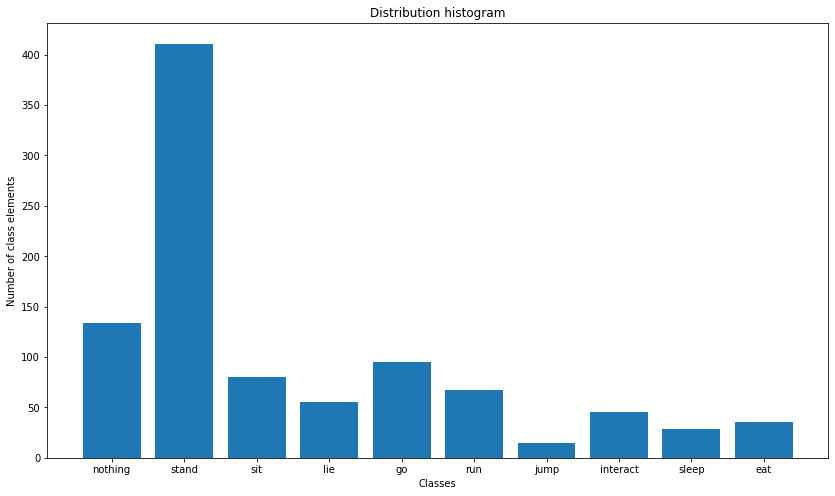

In [ ]:
def distrib_hist(y):
    plt.rcParams['figure.figsize'] = (14, 8)
    levels = list(sum(list(y[col])) for col in y.columns[:-1])
    levels = [len(y)-sum(levels)] + levels
    names = ['nothing'] + list(y.columns[:-1])

    plt.bar(range(10), levels);
    plt.xticks(range(10), names);
    plt.ylabel('Number of class elements')
    plt.xlabel('Classes')
    plt.title("Distribution histogram");

distrib_hist(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

In [ ]:
coord_columns = []
for c in range(len(X_train.columns)):
    column = X_train.columns[c]
    if '_x' in column or '_width' in column or '_y' in column or '_height' in column:
        coord_columns.append(c)

delta = 0.001

next_idx = float(max(list(map(int, X_train.index))) + 1)

for idx in list(map(int, X_train.index)):
    features = list(X_train.loc[idx])
    answers = list(y_train.loc[idx])

    if answers[-1] not in [0, 1]:
        for cc in coord_columns:
            if features[cc] != 0:
                features[cc] += random.uniform(-delta, delta)
        X_train = X_train.append(pd.Series(features, index=X_train.columns, name=next_idx))
        y_train = y_train.append(pd.Series(answers, index=y_train.columns, name=next_idx))
        next_idx += 1

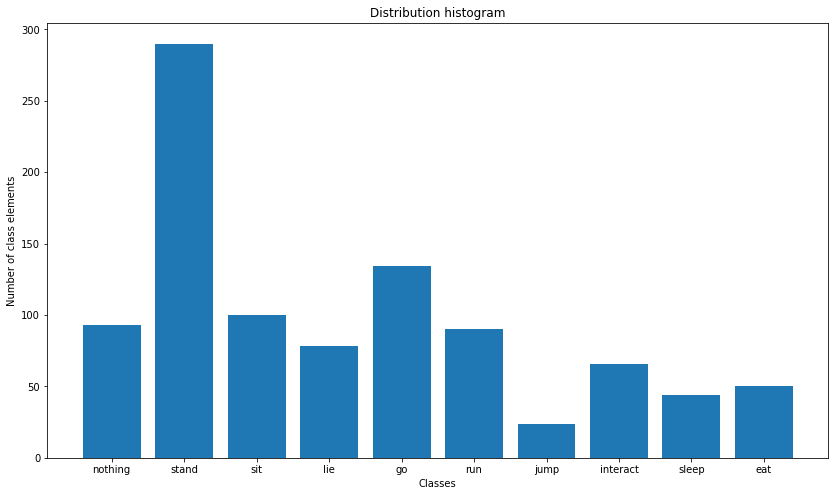

In [ ]:
distrib_hist(y_train)

# LightGBM Classifier
0.4261

In [ ]:
params = {'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 10,
        'metric': 'multi_logloss',
        'learning_rate': 0.003,
        'max_depth': 10,
        'num_leaves': 20}

d_train = lgbm.Dataset(X_train, label=y_train['label'])

num_epochs = 1000

In [ ]:
lgbm_classifier = lgbm.train(params, d_train, num_epochs)

In [ ]:
y_pred = lgbm_classifier.predict(X_test)

In [ ]:
y_pred = [np.argmax(line) for line in y_pred]

In [ ]:
precision_score(y_pred, y_test['label'], average=None).mean()

0.42230411495378234

# Catboost Classifier
0.6632

In [ ]:
train_pool = Pool(data=X_train, label=y_train['label'])
test_pool = Pool(data=X_test, label=y_test['label']) 

In [ ]:
cat_classifier = CatBoostClassifier(
    loss_function='MultiClass',
    eval_metric='Accuracy',
    use_best_model=True,
    random_state = 22
)

In [ ]:
cat_classifier.fit(train_pool, eval_set=test_pool, verbose=False, plot=False)

In [ ]:
cat_classifier.get_best_score()

{'learn': {'Accuracy': 1.0, 'MultiClass': 0.03606230004037539},
 'validation': {'Accuracy': 0.6494845360824743,
  'MultiClass': 1.0647210060745962}}

In [ ]:
cat_classifier.save_model('cat_classifier')

# MyNet
0.5730

In [ ]:
class AnimalsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = csv_file
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_idx = self.data.iloc[idx, 0]
        img_name = os.path.join(self.root_dir, "0"*(3-len(str(img_idx))) + str(img_idx) + ".jpeg")
        image = Image.open(img_name)
        features = self.data.iloc[idx, 1:].to_numpy()

        if self.transform:
            image = self.transform(image)

        sample = (image, features)

        return sample

In [ ]:
target_size = (188, 188)

In [ ]:
train_transforms = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor()
])


for column in df.columns:
    if '_x' in column or '_width' in column or '_y' in column or '_height' in column:
        df[column] = df[column].astype(float)

df_dict = df.to_dict()

for idx in df_dict['id'].values():
    img_name = os.path.join(data_dir, 'animals', "0"*(3-len(str(idx))) + str(idx) + ".jpeg")
    image = Image.open(img_name)
    x_size, y_size = image.size
    for column in df_dict.keys():
        if '_x' in column or '_width' in column:
            df_dict[column][idx] /= x_size
        elif '_y' in column or '_height' in column:
            df_dict[column][idx] /= y_size

df = pd.DataFrame.from_dict(df_dict)

dataset = AnimalsDataset(csv_file=df, root_dir=os.path.join(data_dir, 'animals'), transform=train_transforms)

print(f"Экземпляров в датасете: {len(dataset)}")

Экземпляров в датасете: 967


In [ ]:
train_set, val_set = torch.utils.data.random_split(dataset, [800, 167])

batch_size = 20
num_workers = 0

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [ ]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=3)
        self.conv1_1 = nn.Conv2d(10, 10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv3 = nn.Conv2d(20, 20, kernel_size=3)

        self.fc1 = nn.Linear(1280, 640)
        self.fc2 = nn.Linear(640, 300)
        self.fc3 = nn.Linear(300, 100)
        self.fc4 = nn.Linear(100, 31)

        self.fc5 = nn.Linear(100, 60)
        self.fc6 = nn.Linear(60, 30)
        self.fc7 = nn.Linear(30, 20)
        self.fc8 = nn.Linear(20, 9)

        self.dropout = nn.Dropout2d()

    
    def forward(self, x, x1):
        # input is 256x256x3
        # conv1(kernel=3, filters=10)x2 188x188x3 -> 184x184x10
        # max_pool(kernel=2) 184x184x10 -> 92x92x10
        x = F.relu(F.max_pool2d(self.conv1_1(self.conv1(x)), 2))
        
        # conv2(kernel=3, filters=20)x2 92x92x10 -> 88x88x20
        # max_pool(kernel=2) 88x88x20 -> 44x44x20
        x = F.relu(F.max_pool2d(self.dropout(self.conv3(self.conv2(x))), 2))

        # conv2(kernel=3, filters=20)x2 44x44x20 -> 40x40x20
        # max_pool(kernel=2) 40x40x20 -> 20x20x20
        x = F.relu(F.max_pool2d(self.dropout(self.conv3(self.conv3(x))), 2))

        # conv2(kernel=3, filters=20)x2 20x20x20 -> 16x16x20
        # max_pool(kernel=2) 16x16x20 -> 8x8x20
        x = F.relu(F.max_pool2d(self.dropout(self.conv3(self.conv3(x))), 2))
        
        # flatten 8x8x20 = 1280
        x = x.view(-1, 1280)
        
        # 1280 -> 640
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)

        # 640 -> 300
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)

        # 300 -> 100
        x = F.relu(self.fc3(x))
        x = F.dropout(x, training=self.training)
        
        # 100 -> 31
        x = F.log_softmax(self.fc4(x))
        
        # 31 + 69 = 100
        x = torch.cat((x, x1), dim=1).float()

        # 100 -> 60
        x = F.relu(self.fc5(x))
        x = F.dropout(x, training=self.training)

        # 60 -> 30
        x = F.relu(self.fc6(x))
        x = F.dropout(x, training=self.training)

        # 30 -> 20
        x = F.relu(self.fc7(x))
        x = F.dropout(x, training=self.training)

        # 20 -> 9
        x = F.relu(self.fc8(x))
        x = F.dropout(x, training=self.training)

        return F.log_softmax(x)

In [ ]:
model = MyNet()
model.to(device)

criterion = nn.NLLLoss()

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, amsgrad=True, lr=0.001)

loss_history = {'train':[], 'test':[]}
acc_history = []

In [ ]:
def train():
    model.train()

    running_loss = 0.
    for images, targets in train_dataloader:
        images = images.to(device)
        targets = targets.to(device)
        x2, answers = targets[:, :-9], torch.max(targets[:, -9:], 1)[1]

        images = Variable(images)
        x2 = Variable(x2)
        answers = Variable(answers)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            preds = model(images, x2)

            loss = criterion(preds, answers)
            loss.backward()
            running_loss += loss.item() / len(images)

            optimizer.step()

    epoch_loss = running_loss/len(train_dataloader)
    loss_history['train'].append(epoch_loss)
    print('TRAIN Average loss: {:.4f}'.format(epoch_loss))

In [ ]:
def test():
    model.eval()

    running_loss = 0.
    correct = 0
    for images, targets in val_dataloader:
        images = images.to(device)
        targets = targets.to(device)
        x2, answers = targets[:, :-9], torch.max(targets[:, -9:], 1)[1]

        images = Variable(images)
        x2 = Variable(x2)
        answers = Variable(answers)
        
        with torch.no_grad():
            preds = model(images, x2)
            loss = criterion(preds, answers)
            running_loss += loss.item() / len(images)

            pred = torch.max(preds.data, 1)[1]
            correct += pred.eq(answers.data).cpu().sum() / len(images)


    epoch_loss = running_loss/len(val_dataloader)
    loss_history['test'].append(epoch_loss)
    accuracy = correct / len(val_dataloader)
    acc_history.append(accuracy)
    print('TEST  Average loss: {:.4f}, Accuracy: {:.4f}\n'.format(epoch_loss, accuracy))

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
    print("Epoch %d" % epoch)
    train()
    test()

Epoch 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


TRAIN Average loss: 0.1081
TEST  Average loss: 0.1137, Accuracy: 0.5730

Epoch 1
TRAIN Average loss: 0.1057
TEST  Average loss: 0.1193, Accuracy: 0.5421

Epoch 2
TRAIN Average loss: 0.1014
TEST  Average loss: 0.1193, Accuracy: 0.5214

Epoch 3
TRAIN Average loss: 0.0997
TEST  Average loss: 0.1116, Accuracy: 0.5730

Epoch 4
TRAIN Average loss: 0.0983
TEST  Average loss: 0.1126, Accuracy: 0.5421

Epoch 5
TRAIN Average loss: 0.0989
TEST  Average loss: 0.1151, Accuracy: 0.5317

Epoch 6
TRAIN Average loss: 0.0988
TEST  Average loss: 0.1097, Accuracy: 0.5627

Epoch 7
TRAIN Average loss: 0.0971
TEST  Average loss: 0.1116, Accuracy: 0.5627

Epoch 8
TRAIN Average loss: 0.0977
TEST  Average loss: 0.1152, Accuracy: 0.5421

Epoch 9
TRAIN Average loss: 0.0973
TEST  Average loss: 0.1146, Accuracy: 0.5421

Epoch 10
TRAIN Average loss: 0.0967
TEST  Average loss: 0.1071, Accuracy: 0.5627

Epoch 11
TRAIN Average loss: 0.0975
TEST  Average loss: 0.1154, Accuracy: 0.5524

Epoch 12
TRAIN Average loss: 0.094

Best loss train: 0.0947
Best loss test: 0.1010


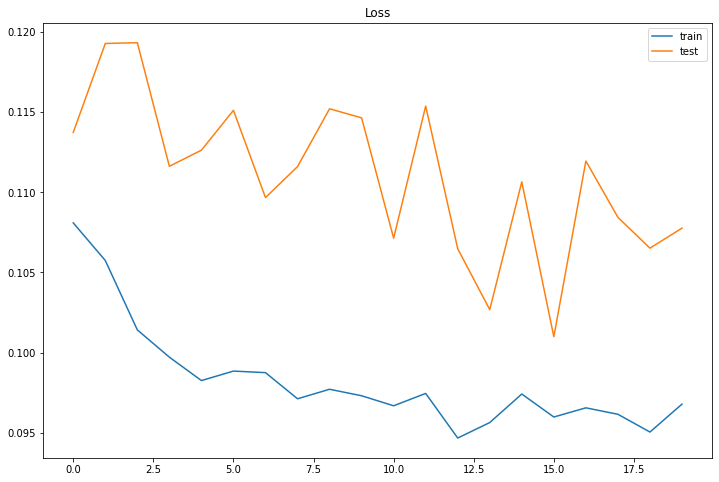


Best acc: 0.5730


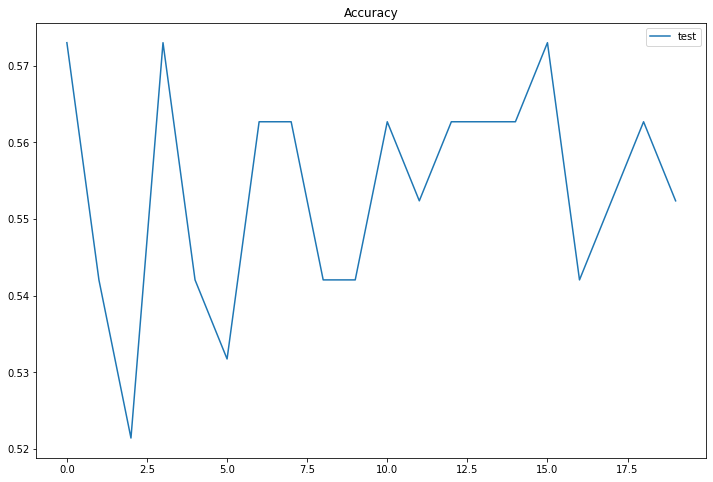

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.plot(loss_history['train'], label='train')
plt.plot(loss_history['test'], label='test')
plt.legend()
plt.title('Loss');
print('Best loss train: {:.4f}'.format(min(loss_history['train'])))
print('Best loss test: {:.4f}'.format(min(loss_history['test'])))
plt.show()

print()

plt.plot(acc_history, label='test')
plt.legend()
plt.title('Accuracy');
print('Best acc: {:.4f}'.format(max(acc_history)))
plt.show()